In [12]:
import xarray as xr
from pathlib import Path
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data

import wavenumber as waves

In [13]:
data_path = Path('/home/links/ct715/data_storage/reanalysis/srip_datasets')

models = ['JRA55', 'NCEP-NCAR', 'ERA-Interim']
# models = ['JRA55']
dataset_type = ['TEM', 'ZMD']

ds = {}
for model in models:
    
    # set paths and import datasets into one set
    dataset_paths = data_path.glob(f'{model}_*_monthly_original.nc')
    dataset = xr.open_mfdataset(
        dataset_paths,
        parallel=True
    )
    
    # bespoke changes
    dataset = dataset.rename({'u': 'ubar'})

    # save to dataset dict
    ds[model] = dataset
    
era = ds['ERA-Interim']
jra = ds['JRA55']

In [14]:
for model in ds:
    print(f"{model}: {ef.calculate_efp(ds[model], data_type='reanalysis', which_div1='EPFD_phi_pr')}")
    
    ds[model]['k1-3'] = ds[model].EPFD_phi_pr_k1 + ds[model].EPFD_phi_pr_k2 + ds[model].EPFD_phi_pr_k3
    ds[model]['k>3'] = ds[model].EPFD_phi_pr - ds[model]['k1-3']
    
    # ds[model] = data.data_checker1000(ds[model])
  
wavenumber = ['k1', 'k2', 'k3']  
other_waves = ['k1-3', 'k>3']

JRA55: 0.45019999146461487
NCEP-NCAR: 0.4399999976158142
ERA-Interim: 0.44209998846054077


# EFP Components

- For whatever reason, JRA doesn't show colours yet still has a scale? Can investigate if needed...

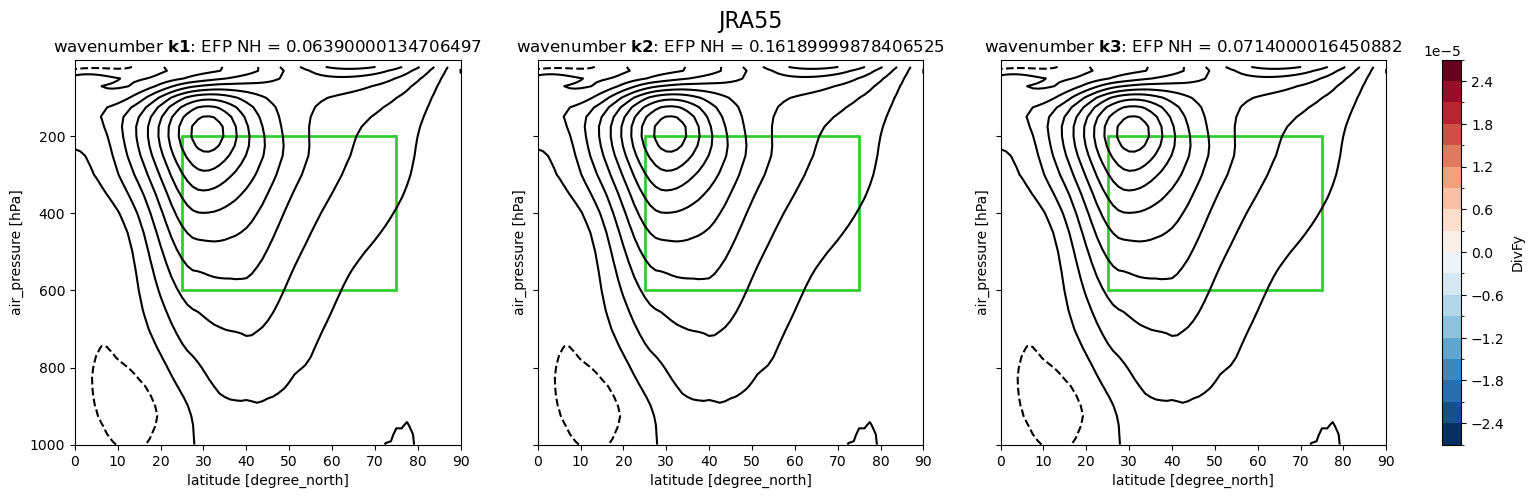

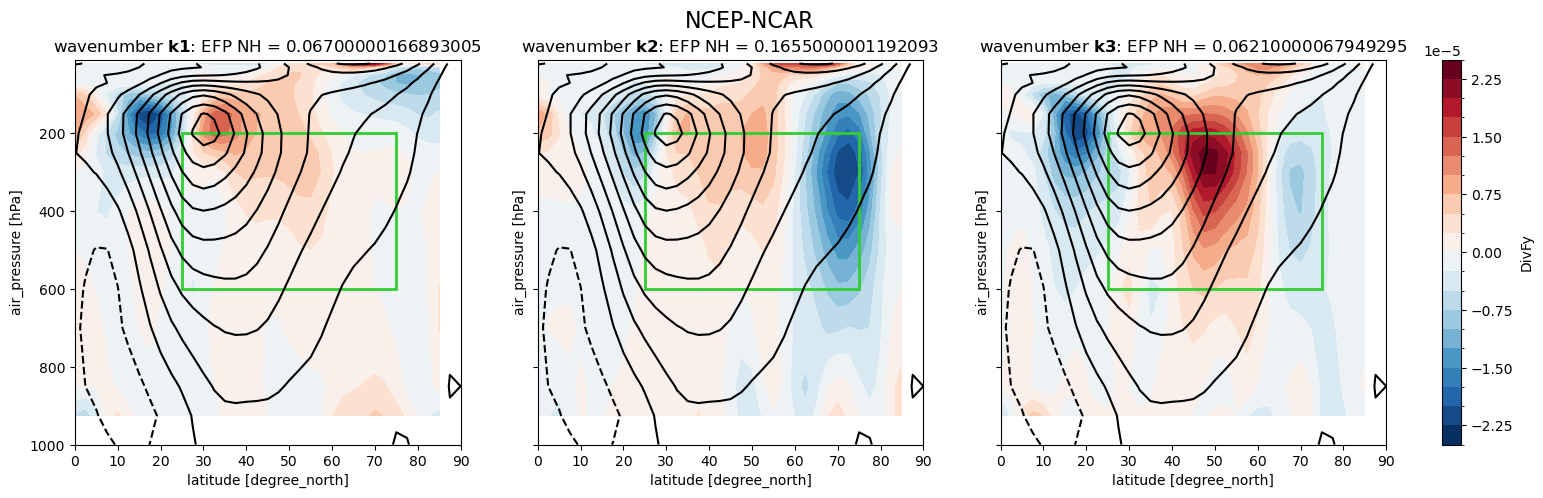

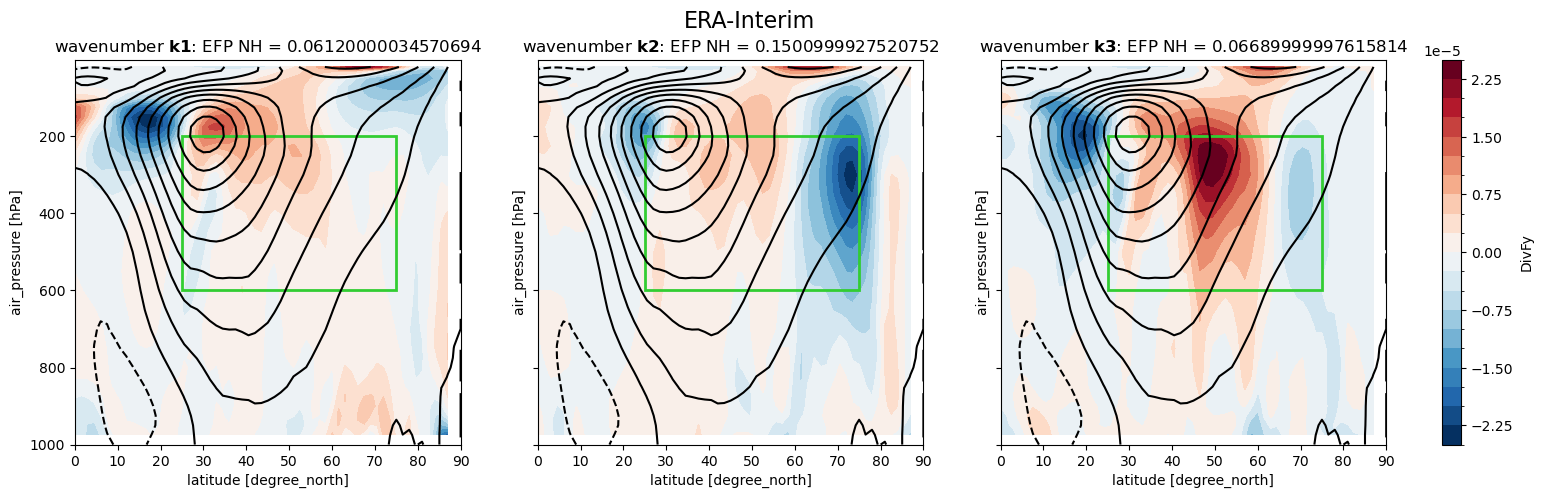

In [15]:
for model in ds:
    
    fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharey=True)
    contourfs = []
    for ax, n in zip(axes, wavenumber):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}')
        contourf = waves.plot_wavenumber_EFP_components(ax, ds[model], data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}', 
                                    hemisphere='NH', title=f'wavenumber $\\mathbf{{{n}}}$: EFP NH = {efp}')
        contourfs.append(contourf)

    # Add shared colorbar
    cbar = fig.colorbar(contourfs[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('DivFy')

    fig.suptitle(f'{model}', fontsize=16)
    plt.show()

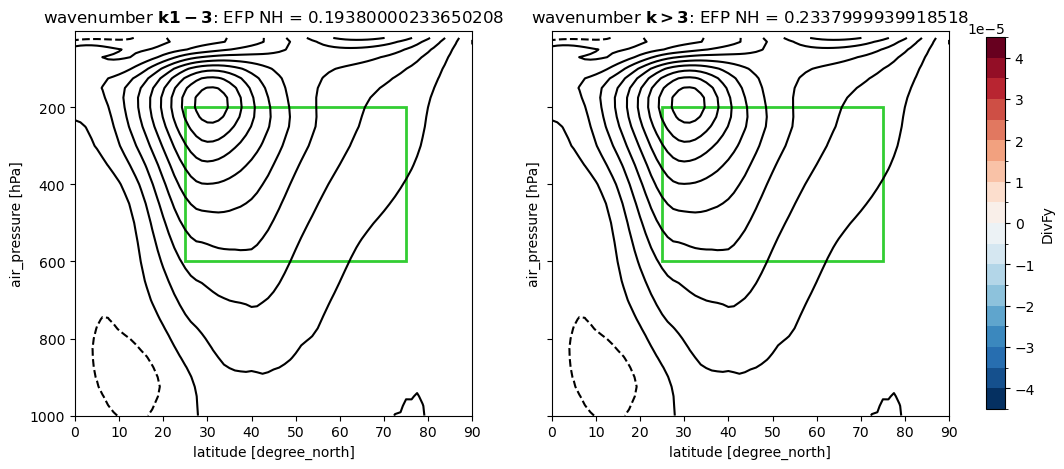

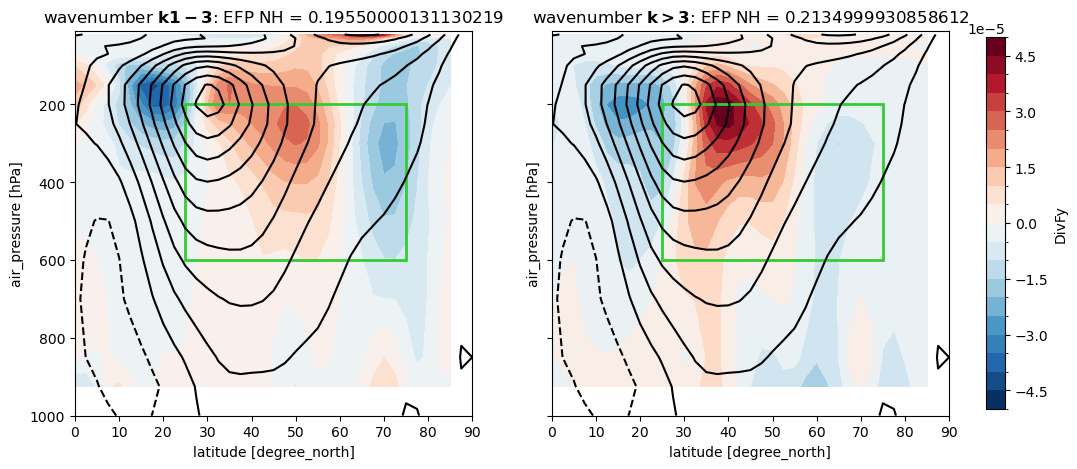

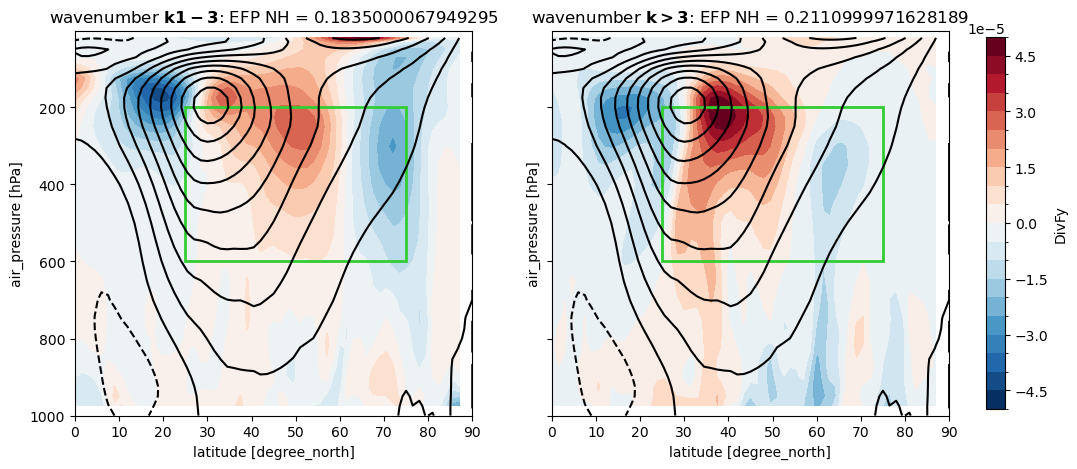

In [16]:
for model in ds:
    
    # plot 'em 
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
    contourfs = []
    for ax, n in zip(axes, other_waves):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n)
        contourf = waves.plot_wavenumber_EFP_components(ax, ds[model], data_type='reanalysis', which_div1=n, 
                                    hemisphere='NH', title=f'wavenumber $\\mathbf{{{n}}}$: EFP NH = {efp}')
        contourfs.append(contourf)

    # Add shared colorbar
    cbar = fig.colorbar(contourfs[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('DivFy')

    plt.show()

***

# Plot correlations

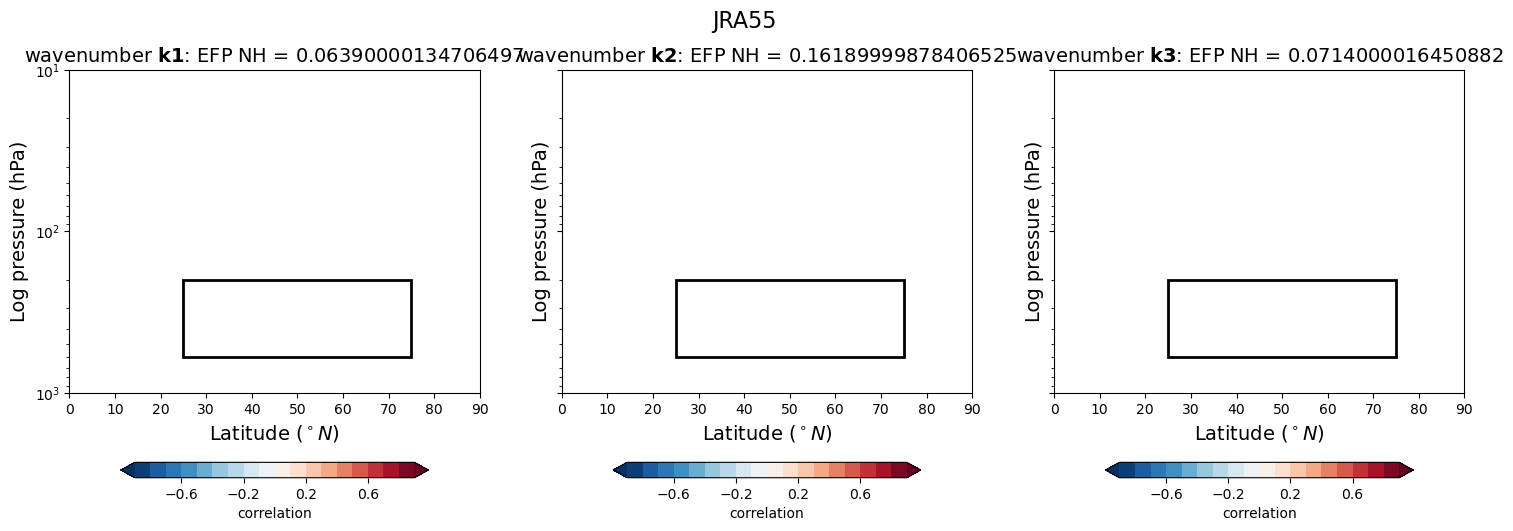

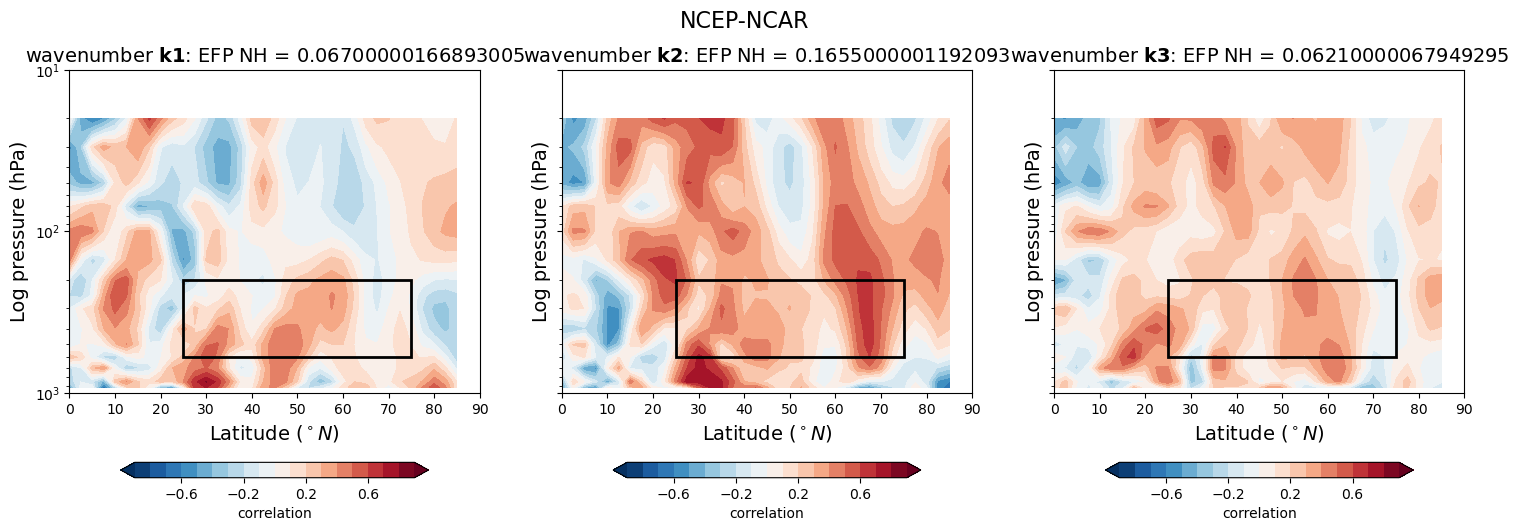

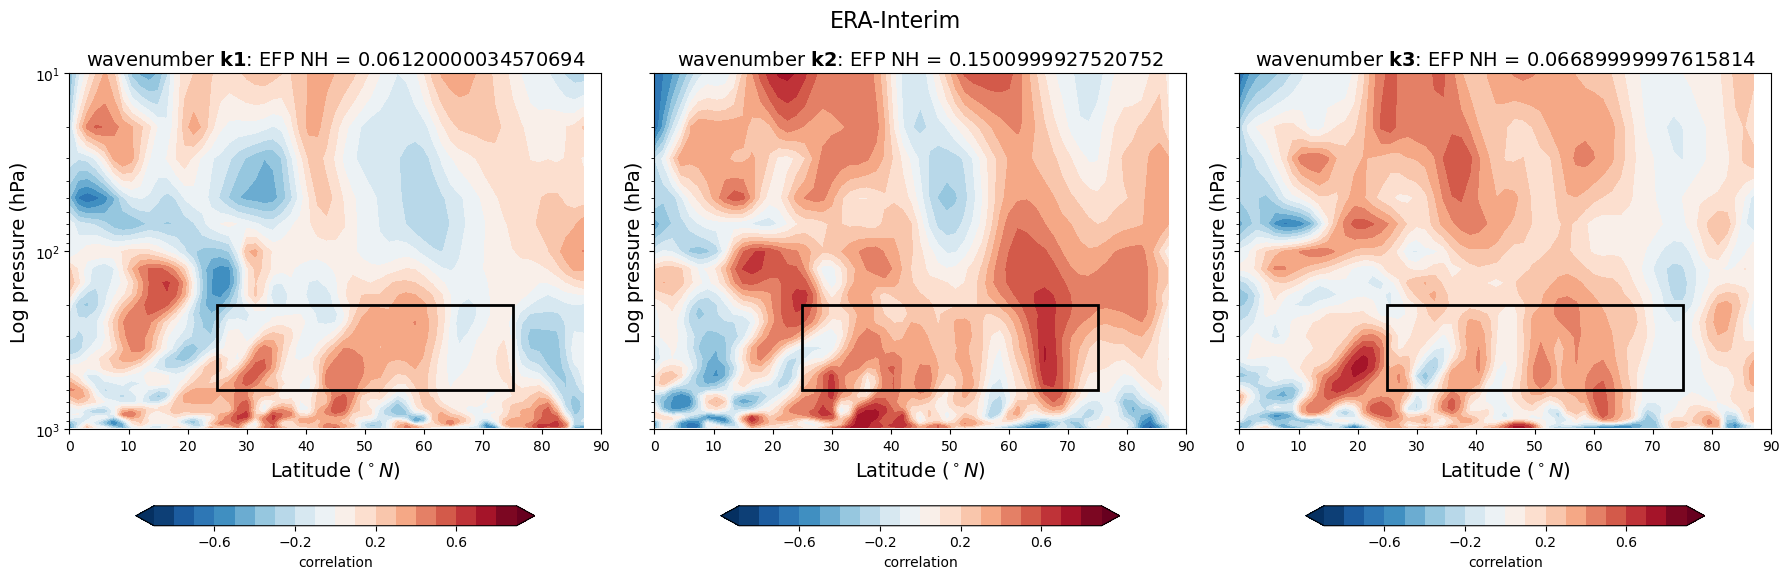

In [17]:
for model in ds:
    fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)

    for ax, n in zip(axes, wavenumber):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}')
        efp = efp.round(4)
        waves.plot_wavenumber_EFP_correlation(ax, ds[model], data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}', 
                            hemisphere='NH', title=f'wavenumber $\\mathbf{{{n}}}$: EFP NH = {efp}')
        
    fig.suptitle(model, fontsize=16)

plt.tight_layout()
plt.show()

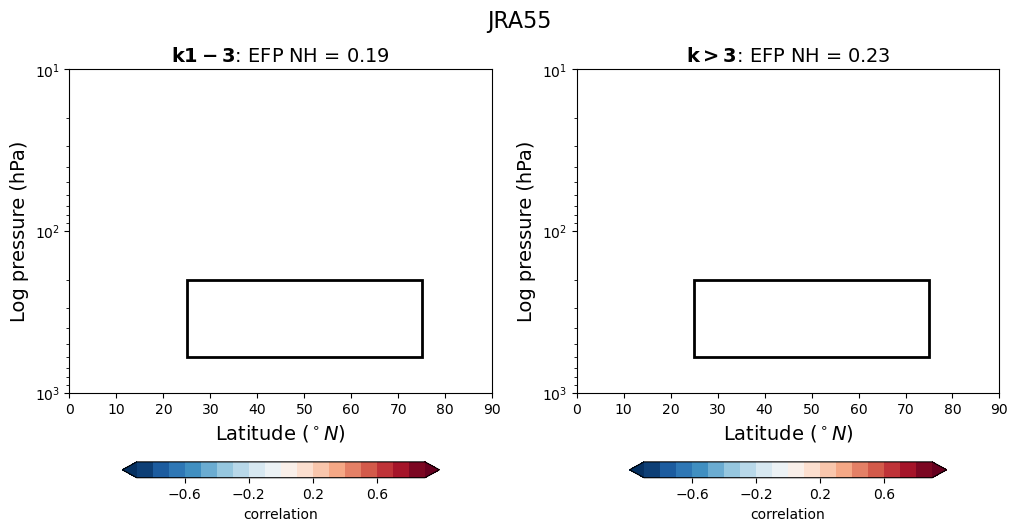

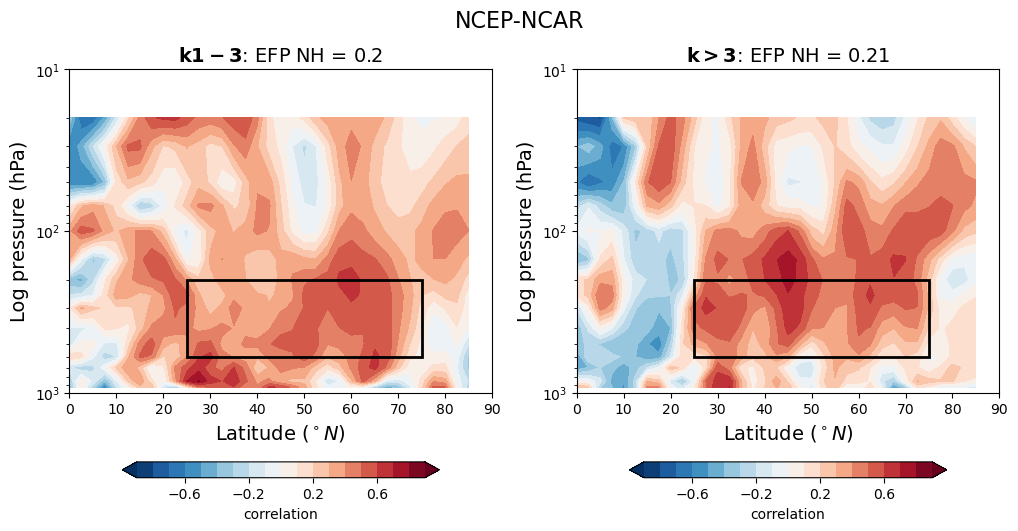

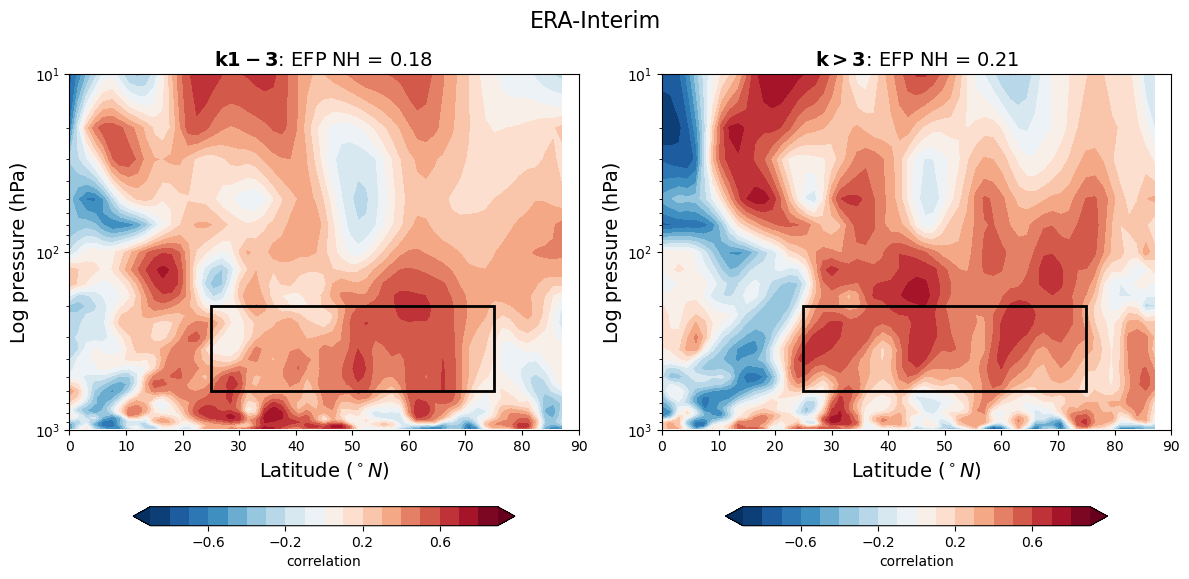

In [18]:
for model in ds:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    for ax, n in zip(axes, other_waves):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n)
        efp = efp.round(4)
        waves.plot_wavenumber_EFP_correlation(ax, ds[model], data_type='reanalysis', which_div1=n, hemisphere='NH', title=f'$\\mathbf{{{n}}}$: EFP NH = {round(float(efp),2)}')

    fig.suptitle(model, fontsize=16)

plt.tight_layout()
plt.show()

# Southern Hemisphere

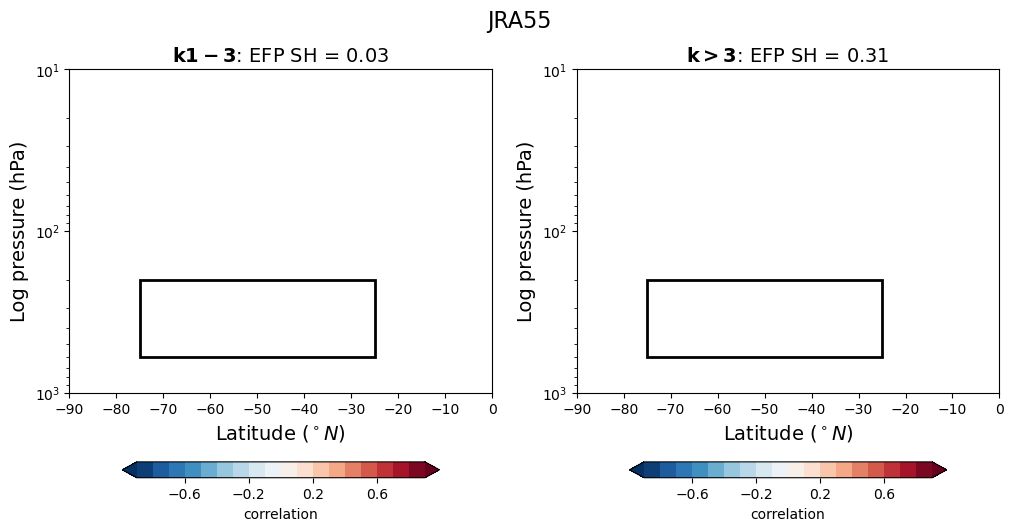

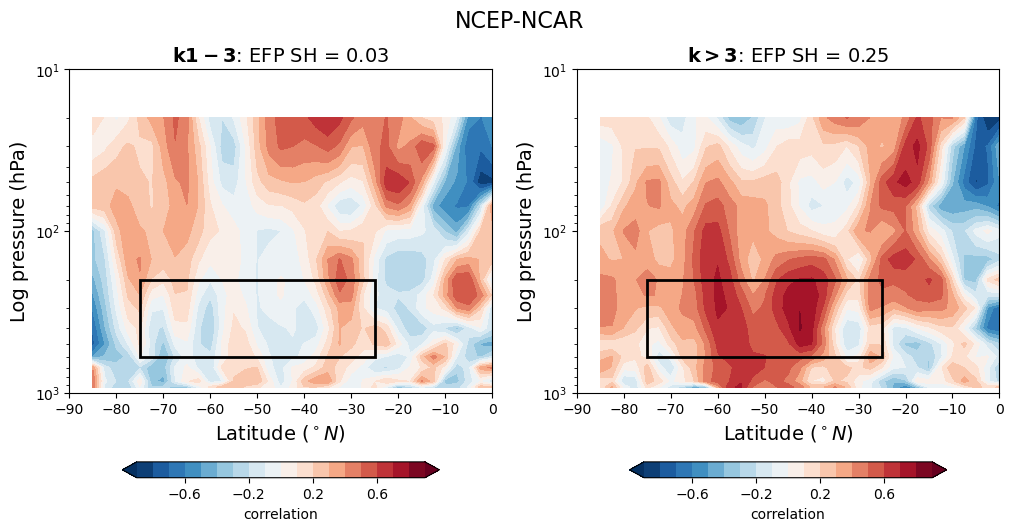

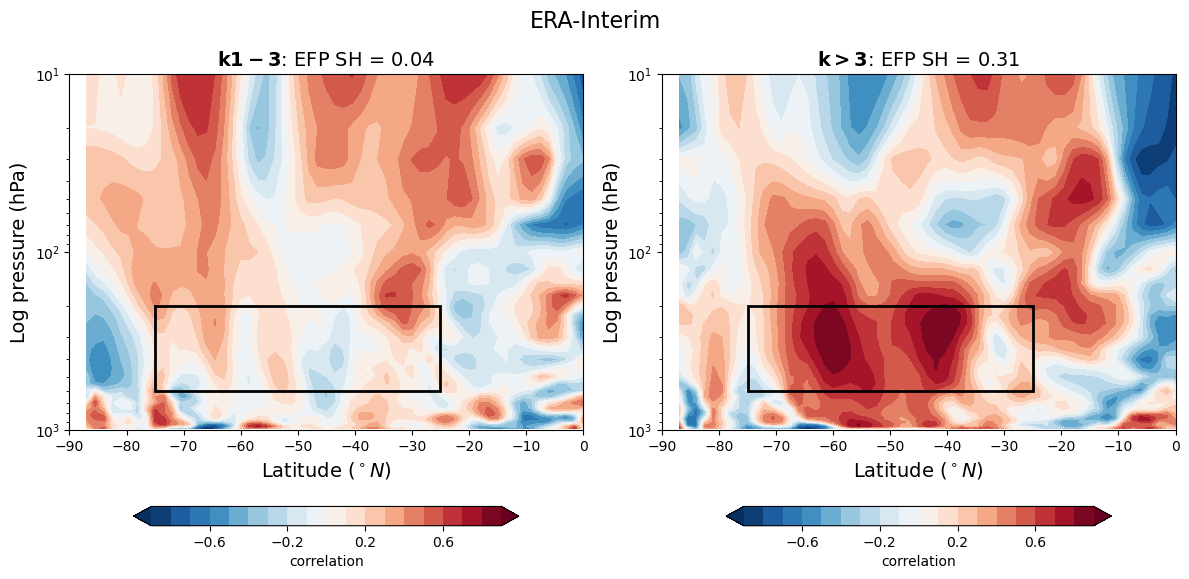

In [19]:
for model in ds:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    for ax, n in zip(axes, other_waves):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n, calc_south_hemis=True)
        efp = efp.round(4)
        waves.plot_wavenumber_EFP_correlation(ax, ds[model], data_type='reanalysis', which_div1=n, hemisphere='SH', title=f'$\\mathbf{{{n}}}$: EFP SH = {round(float(efp),2)}')

    fig.suptitle(model, fontsize=16)

plt.tight_layout()
plt.show()